In [1]:
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
y = data.target
class_names = data.target_names

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Liczność zbioru uczącego:", len(X_train))
print("Liczność zbioru testowego:", len(X_test))

Liczność zbioru uczącego: 133
Liczność zbioru testowego: 45


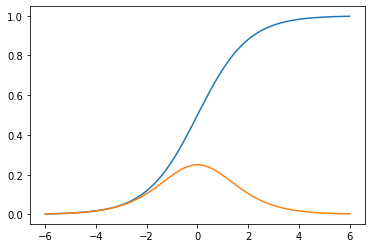

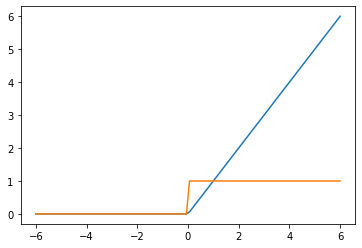

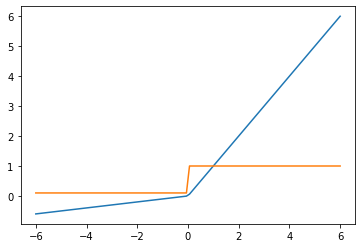

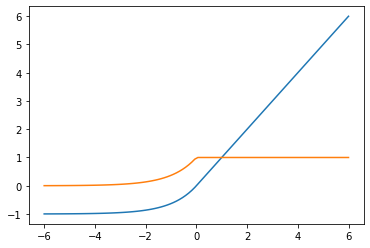

In [4]:
from mlp import sigmoid, relu, leakyrelu, d_sigmoid_dt, d_relu_dt, d_leakyrelu_dt, elu, d_elu_dt
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
for i in range(len(x)):
    y[i] = sigmoid(x[i])
plt.plot(x, y)
for i in range(len(x)):
    y[i] = d_sigmoid_dt(x[i])
plt.plot(x, y)
plt.show()


for i in range(len(x)):
    y[i] = relu(x[i])
plt.plot(x, y)
for i in range(len(x)):
    y[i] = d_relu_dt(x[i])
plt.plot(x, y)
plt.show()


for i in range(len(x)):
    y[i] = leakyrelu(x[i])
plt.plot(x, y)
for i in range(len(x)):
    y[i] = d_leakyrelu_dt(x[i])
plt.plot(x, y)
plt.show()

for i in range(len(x)):
    y[i] = elu(x[i])
plt.plot(x, y)
for i in range(len(x)):
    y[i] = d_elu_dt(x[i])
plt.plot(x, y)
plt.show()